In [1]:
import os
import sys
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path

# Add project root to path to import experiment manager
sys.path.append('/home/minhang/mds_project/sc_classification')
from utils.experiment_manager import ExperimentManager

/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_

In [ ]:
# --- Configuration ---
# Replace with your actual experiment ID
experiment_id = "20250714_205422_fa_100_random_6dbbde08" 
patient_id = "P01"
# Define the 1-based index range for regularization strengths to inspect
# Alphas are stored from weakest to strongest regularization.
# Let's say you want to check the 12th, 13th, and 14th alpha values.
reg_strength_indices_to_check = [12, 13, 14]

# --- Setup ---
experiments_dir = '/home/minhang/mds_project/sc_classification/experiments/'
experiment_manager = ExperimentManager(experiments_dir)
experiment = experiment_manager.load_experiment(experiment_id)

Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250714_205422_fa_100_random_6dbbde08


In [3]:
experiment.experiment_dir

PosixPath('/home/minhang/mds_project/sc_classification/experiments/20250714_205422_fa_100_random_6dbbde08')

In [4]:
# --- Load Data ---
print(f"Loading data for patient {patient_id} from experiment {experiment_id}...")

# 1. Load preprocessed AnnData
preprocessed_adata_path = experiment.experiment_dir / "preprocessing" / "adata_processed.h5ad"
adata_full = sc.read_h5ad(preprocessed_adata_path)
adata_patient_full = adata_full[adata_full.obs['patient'] == patient_id].copy()
print(f"Loaded patient AnnData with {adata_patient_full.n_obs} cells.")

# 2. Load classification correctness data
correctness_path = experiment.experiment_dir / "models" / "classification" / patient_id / "classification_correctness.csv"
if not correctness_path.exists():
    raise FileNotFoundError(f"Classification correctness file not found at: {correctness_path}\nPlease rerun the pipeline to generate it.")
correctness_df = pd.read_csv(correctness_path, index_col=0)
barcodes_for_classification = correctness_df.index.tolist()

Loading data for patient P01 from experiment 20250714_205422_fa_100_random_6dbbde08...
Loaded patient AnnData with 18964 cells.


In [9]:
transformed_adata = sc.read_h5ad(experiment.experiment_dir / "models" / "fa_100" / "transformed_data.h5ad")

In [10]:
transformed_adata

AnnData object with n_obs × n_vars = 69801 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'library', 'exp.ID', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_dsb', 'nFeature_dsb', 'nCount_ADT', 'nFeature_ADT', 'hash.ID', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'Lane', 'patient', 'marker', 'Time', 'batch', 'Tech', 'sample', 'source', 'soup.singlet_posterior', '_indices', '_scvi_batch', '_scvi_labels', 'CN.label', 'predicted.annotation.score', 'predicted.annotation', 'predicted.pseudotime.score', 'predicted.pseudotime', 'timepoint_type'
    var: 'ID', 'modality', 'chr', 'start', 'end', 'highly_variable', 'communality'
    uns: 'CN.label_colors', 'Tech_colors', 'draw_graph', 'fa', 'neighbors', 'patient_colors', 'predicted.annotation_colors', 'sample_colors', 'timepoint_type_colors', 'umap'
    obsm: 'X_draw_graph_fa', 'X_fa', 'X_multivi', 'X_umap'
    varm: 'FA_loadings'
    obsp: 'connectivities', 'distances'

In [5]:
# 3. Subset the patient AnnData to ONLY include the cells used in classification
adata_patient = adata_patient_full[barcodes_for_classification].copy()
print(f"Subsetting to {adata_patient.n_obs} cells for UMAP and plotting.")

Subsetting to 759 cells for UMAP and plotting.


In [6]:
# --- Recompute UMAP for the Patient ---
print("Recomputing UMAP for the patient subset...")
# Note: The user mentioned 'X_multivi', but the standard pipeline produces 'X_fa' or 'X_nmf'.
# I'll check the config to use the correct one.
# dr_method = experiment.config.config['dimension_reduction']['method']
use_rep = f'X_multivi'
if use_rep not in adata_patient.obsm:
    raise KeyError(f"Representation '{use_rep}' not found in AnnData. Please check the DR method.")

sc.pp.neighbors(adata_patient, use_rep=use_rep, random_state=42)
sc.tl.umap(adata_patient, min_dist=0.5, spread=1.0, random_state=42)

Recomputing UMAP for the patient subset...


Generating UMAP plots for specified regularization strengths...
Plotting for alpha index 12 (alpha_1.62e+01)


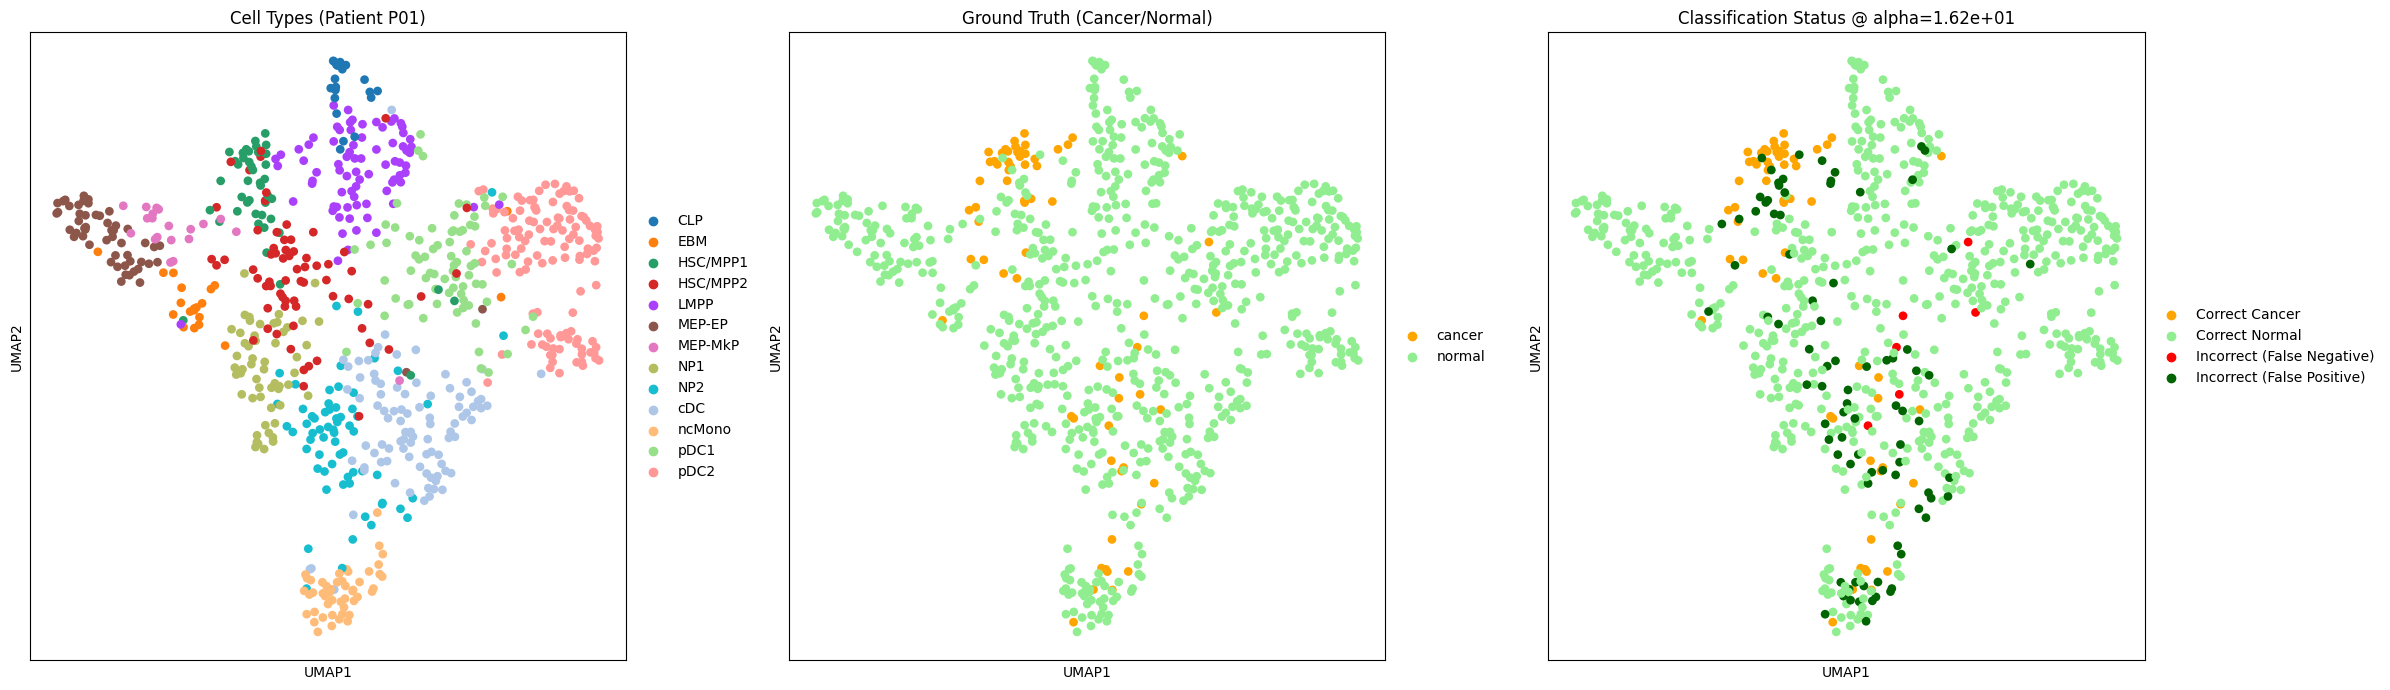

Plotting for alpha index 13 (alpha_4.83e+01)


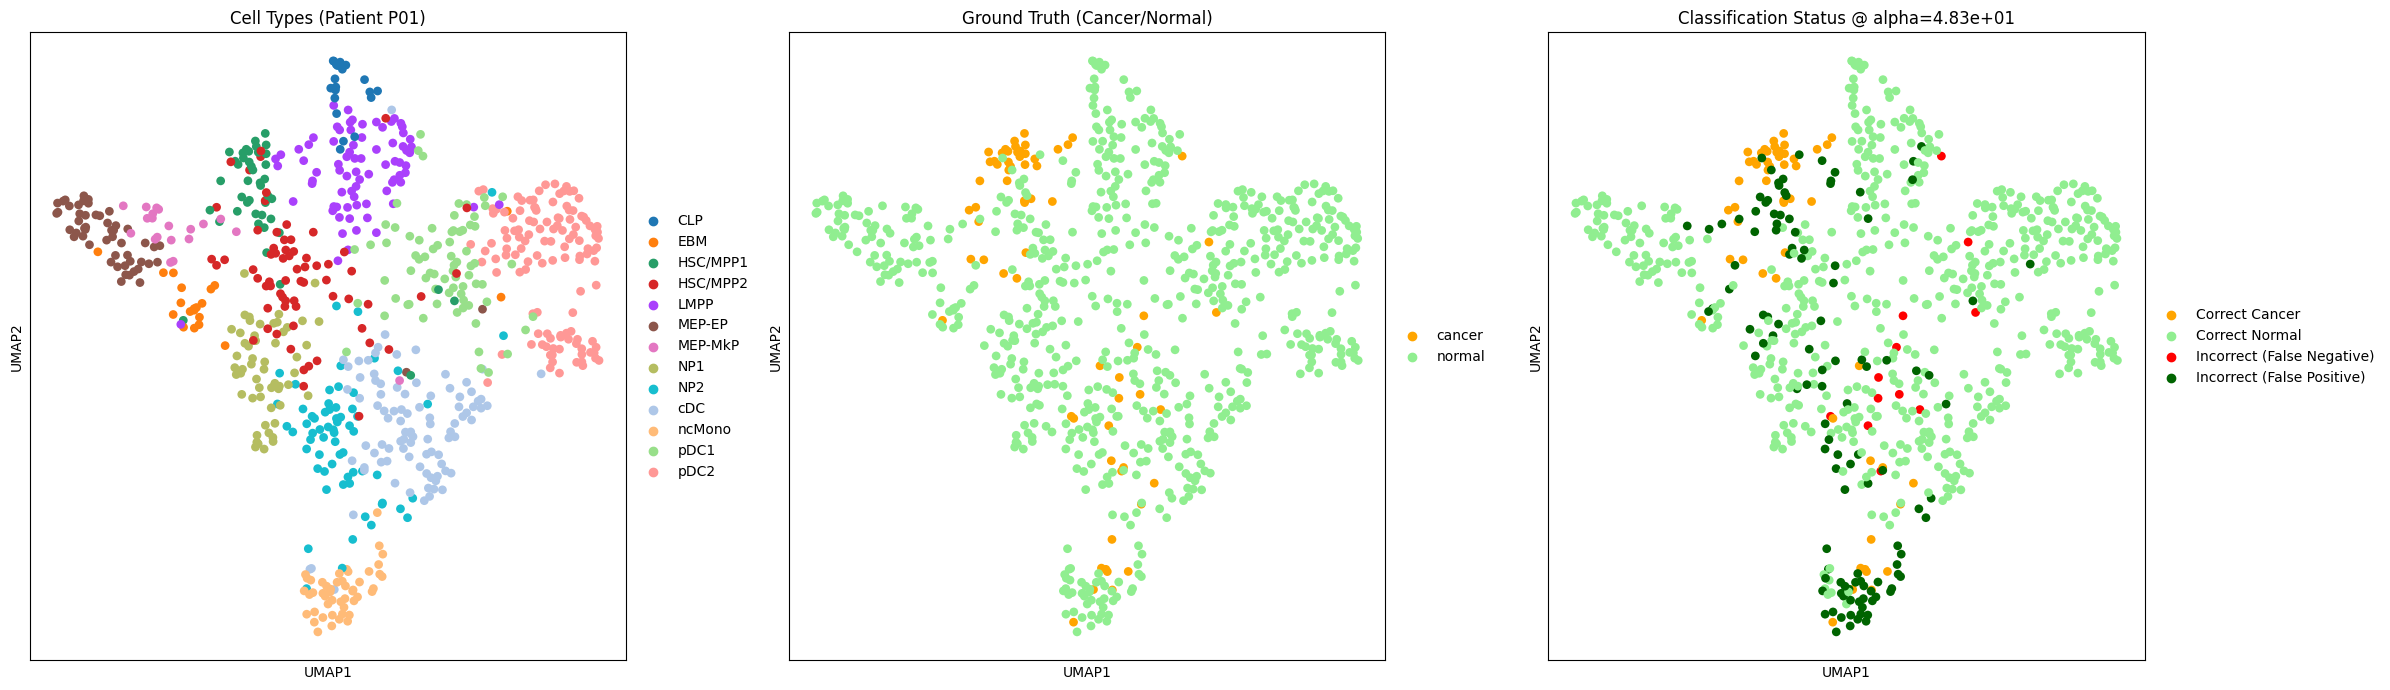

Plotting for alpha index 14 (alpha_1.44e+02)


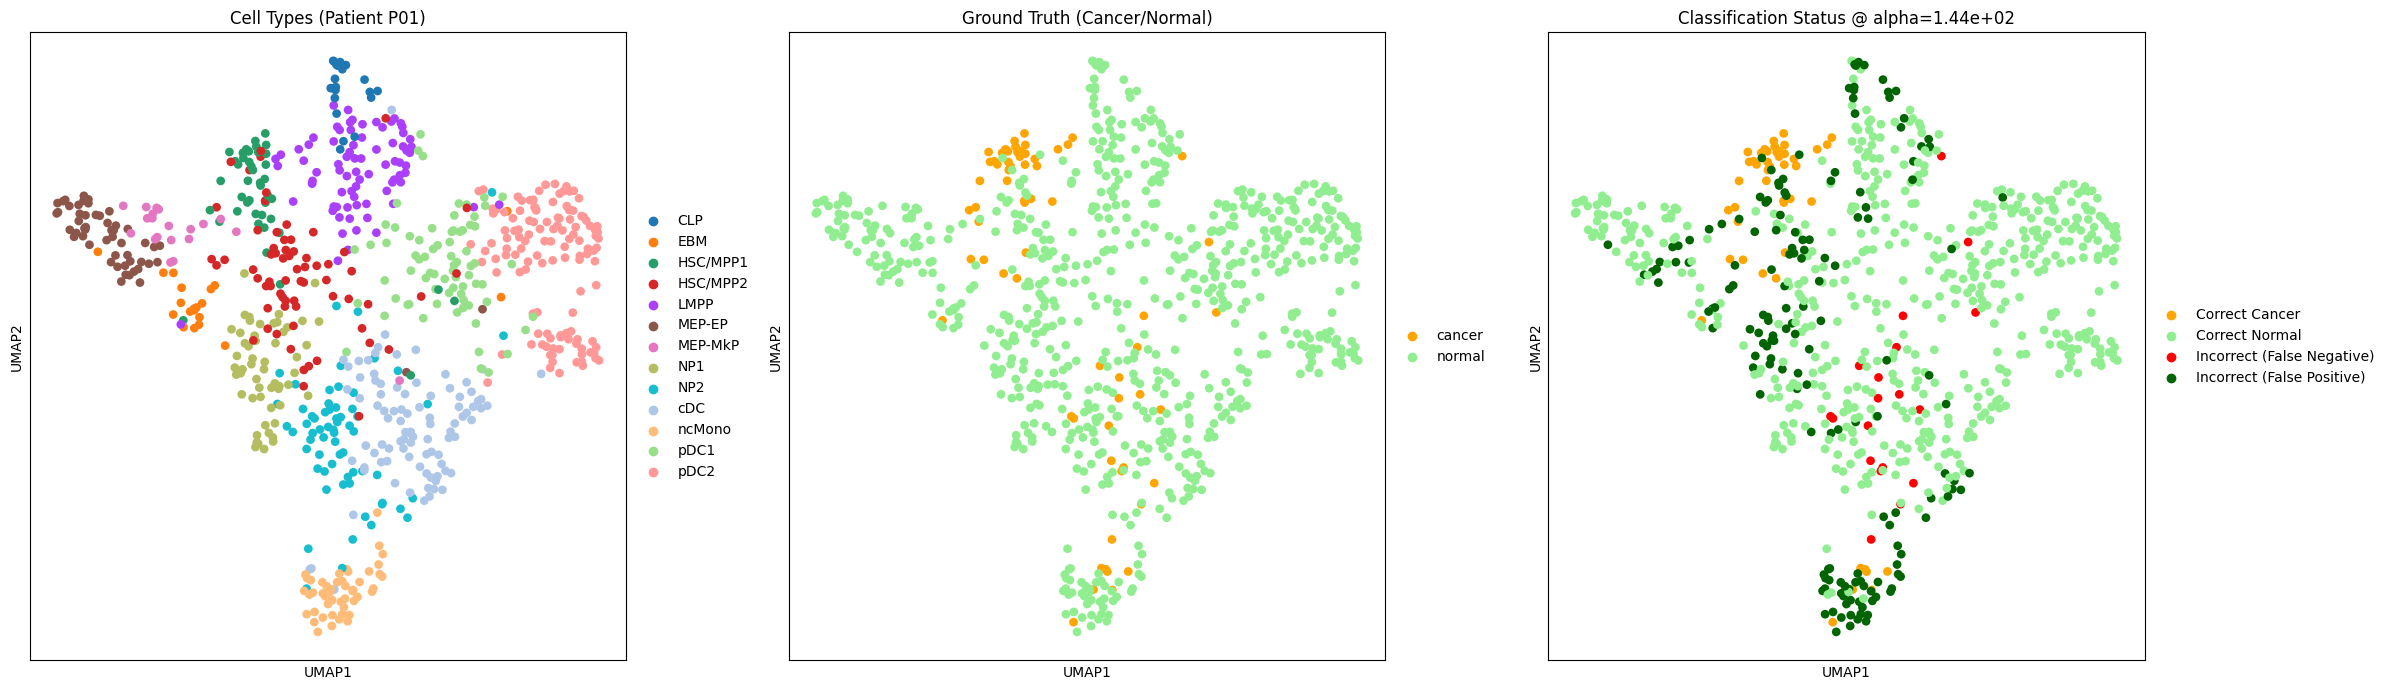

In [ ]:
# --- Define Color Palettes ---
positive_class = experiment.config.config['preprocessing'].get('positive_class', 'cancer')
negative_class = experiment.config.config['preprocessing'].get('negative_class', 'normal')

# Palette for the Ground Truth plot
cn_label_palette = {
    positive_class: 'orange',
    negative_class: 'lightgreen'
}

# Palette for the 4-category Classification Status plot
status_palette = {
    f'Correct {positive_class.capitalize()}': 'orange',     # Consistent with ground truth
    'Correct Normal': 'lightgreen',                         # Consistent with ground truth
    'Incorrect (False Negative)': 'red',                    # A cancer cell that was misidentified as normal
    'Incorrect (False Positive)': 'darkgreen'               # A normal cell misidentified as cancer
}

# --- Plotting Loop ---
print("Generating UMAP plots for specified regularization strengths...")
alpha_indices = [i - 1 for i in reg_strength_indices_to_check] 

for alpha_idx in alpha_indices:
    if alpha_idx >= len(correctness_df.columns):
        print(f"Warning: Index {alpha_idx+1} is out of bounds. Skipping.")
        continue
    
    alpha_col_name = correctness_df.columns[alpha_idx]
    
    # --- Create the 4-category classification status ---
    correctness = correctness_df[alpha_col_name]
    ground_truth_labels = adata_patient.obs['CN.label']
    
    conditions = [
        (correctness) & (ground_truth_labels == positive_class),
        (correctness) & (ground_truth_labels != positive_class),
        (~correctness) & (ground_truth_labels == positive_class),
        (~correctness) & (ground_truth_labels != positive_class)
    ]
    choices = [
        f'Correct {positive_class.capitalize()}',
        'Correct Normal',
        'Incorrect (False Negative)',
        'Incorrect (False Positive)'
    ]
    adata_patient.obs['classification_status'] = np.select(conditions, choices, default='Unknown')
    adata_patient.obs['classification_status'] = adata_patient.obs['classification_status'].astype('category')
    
    # Extract alpha value for title
    alpha_val = float(alpha_col_name.split('_')[1])
    
    print(f"Plotting for alpha index {alpha_idx+1} ({alpha_col_name})")
    
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    
    # Plot 1: Colored by Predicted Annotation
    sc.pl.umap(
        adata_patient,
        color='predicted.annotation',
        ax=axes[0],
        show=False,
        title=f'Cell Types (Patient {patient_id})'
    )
    
    # Plot 2: Colored by Cancer/Normal Label with new palette
    sc.pl.umap(
        adata_patient,
        color='CN.label',
        palette=cn_label_palette,
        ax=axes[1],
        show=False,
        title=f'Ground Truth (Cancer/Normal)'
    )

    # Plot 3: Colored by the new 4-category Classification Status with new palette
    sc.pl.umap(
        adata_patient,
        color='classification_status',
        palette=status_palette,
        ax=axes[2],
        show=False,
        title=f'Classification Status @ alpha={alpha_val:.2e}'
    )
    
    plt.tight_layout()
    plt.show()


In [9]:
adata_patient.obs['correctly_classified'].unique()

[False, True]
Categories (2, bool): [False, True]

In [26]:
fa_preprocessed_adata = sc.read_h5ad('/home/minhang/mds_project/sc_classification/experiments/20250714_205422_fa_100_random_6dbbde08/preprocessing/adata_processed.h5ad')

In [27]:
# subset fa_preprocessed_adata into .obs['patient'] == 'P01'
fa_preprocessed_adata_P01 = fa_preprocessed_adata[fa_preprocessed_adata.obs['patient'] == 'P01'].copy()

In [25]:
fa_preprocessed_adata_P01.obs['source'].unique(), fa_preprocessed_adata_P01.obs['CN.label'].unique()

(['donor', 'recipient']
 Categories (2, object): ['donor', 'recipient'],
 ['normal', 'cancer']
 Categories (2, object): ['cancer', 'normal'])

In [ ]:
# plot the UMAP for fa_preprocessed_adata_P01 from obsm['X_multivi'], redo the UMAP and name it 'X_umap_P01',
# and plot the UMAP with color by 'cell_type' and 'CN.label'
sc.pp.neighbors(fa_preprocessed_adata_P01, use_rep='X_multivi')
sc.tl.umap(fa_preprocessed_adata_P01, min_dist=0.5, spread=1.0, random_state=42)


KeyError: 'Could not find key cell_type in .var_names or .obs.columns.'

<Figure size 1455.6x480 with 0 Axes>

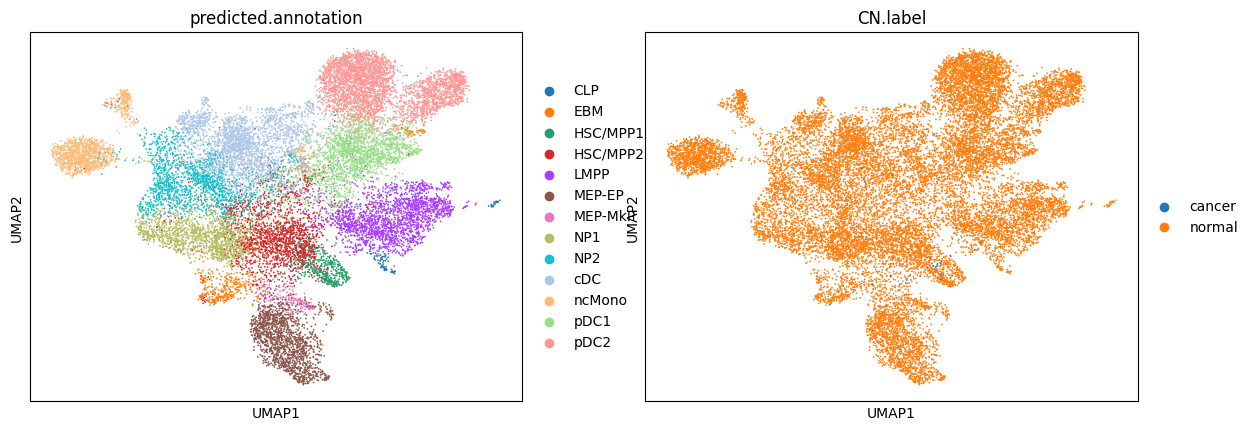

In [12]:
sc.pl.umap(fa_preprocessed_adata_P01, color=['predicted.annotation', 'CN.label'])

In [13]:
fa_preprocessed_adata_P01

AnnData object with n_obs × n_vars = 18964 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'library', 'exp.ID', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_dsb', 'nFeature_dsb', 'nCount_ADT', 'nFeature_ADT', 'hash.ID', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'Lane', 'patient', 'marker', 'Time', 'batch', 'Tech', 'sample', 'source', 'soup.singlet_posterior', '_indices', '_scvi_batch', '_scvi_labels', 'CN.label', 'predicted.annotation.score', 'predicted.annotation', 'predicted.pseudotime.score', 'predicted.pseudotime', 'timepoint_type'
    var: 'ID', 'modality', 'chr', 'start', 'end', 'highly_variable'
    uns: 'CN.label_colors', 'Tech_colors', 'draw_graph', 'neighbors', 'patient_colors', 'predicted.annotation_colors', 'sample_colors', 'timepoint_type_colors', 'umap'
    obsm: 'X_draw_graph_fa', 'X_multivi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [14]:
p01_coefs = pd.read_csv('/home/minhang/mds_project/sc_classification/experiments/20250710_170610_fa_100_random_6dbbde08/models/classification/P01/coefficients.csv', index_col=0)

In [15]:
p01_coefs

,alpha_1.00e-04,alpha_2.98e-04,alpha_8.86e-04,alpha_2.64e-03,alpha_7.85e-03,alpha_2.34e-02,alpha_6.95e-02,alpha_2.07e-01,alpha_6.16e-01,alpha_1.83e+00,alpha_5.46e+00,alpha_1.62e+01,alpha_4.83e+01,alpha_1.44e+02,alpha_4.28e+02,alpha_1.27e+03,alpha_3.79e+03,alpha_1.13e+04,alpha_3.36e+04,alpha_1.00e+05
X_fa_1,-0.269509,-0.268824,-0.267490,-0.263570,-0.255920,-0.240252,-0.204593,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
X_fa_2,2.896691,2.893866,2.883550,2.853629,2.761046,2.517732,1.877949,0.320292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
X_fa_3,-0.756734,-0.756405,-0.754057,-0.746865,-0.717443,-0.615232,-0.249182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
X_fa_4,-0.944799,-0.943663,-0.939981,-0.929311,-0.898243,-0.819713,-0.629648,-0.196011,-0.023061,-0.530539,-0.466051,-0.361218,-0.280382,-0.105336,0.0,0.0,0.0,0.0,0.0,0.0
X_fa_5,-0.686392,-0.683500,-0.675725,-0.652858,-0.591935,-0.436535,-0.203146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X_fa_96,-1.578756,-1.577371,-1.571890,-1.556066,-1.505979,-1.376041,-1.034427,-0.527047,-0.293584,-0.357900,-0.255174,-0.126998,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
X_fa_97,-1.632554,-1.630989,-1.625891,-1.611097,-1.567944,-1.459202,-1.238429,-0.900526,-0.521539,-0.273074,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
X_fa_98,-3.956214,-3.953691,-3.943620,-3.914716,-3.823902,-3.595216,-3.057865,-2.274406,-1.126913,-0.377479,-0.134844,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
X_fa_99,-4.941112,-4.937059,-4.922455,-4.880266,-4.752173,-4.429676,-3.742477,-2.872072,-1.531686,-0.764377,-0.304385,-0.141278,-0.007251,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
p01_metrics = pd.read_csv('/home/minhang/mds_project/sc_classification/experiments/20250710_170610_fa_100_random_6dbbde08/models/classification/P01/metrics.csv', index_col=0)

In [22]:
p01_metrics['group']

tp
65    all_samples
65            P01
65    all_samples
65            P01
65    all_samples
65            P01
65    all_samples
65            P01
65    all_samples
65            P01
65    all_samples
65            P01
65    all_samples
65            P01
65    all_samples
65            P01
65    all_samples
65            P01
65    all_samples
65            P01
63    all_samples
63            P01
59    all_samples
59            P01
53    all_samples
53            P01
46    all_samples
46            P01
0     all_samples
0             P01
0     all_samples
0             P01
0     all_samples
0             P01
0     all_samples
0             P01
0     all_samples
0             P01
0     all_samples
0             P01
Name: group, dtype: object